# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# category_encoders for improved OneHotEncoder
import category_encoders as ce

# sklearn_pandas for imputer of categorical features
#from sklearn_pandas import CategoricalImputer

# Input data files are available in the "data/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data"))

# Any results you write to the current directory are saved as output.

['desktop.ini', 'test.csv', 'train.csv']


# Read data

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

print ("Train data shape:", df_train.shape)
print ("Test data shape:", df_test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


## Data Exploration

In [3]:
#df_train.head()

In [4]:
#df_train.info()

In [5]:
#df_test.info()

Skew is: 1.8828757597682129


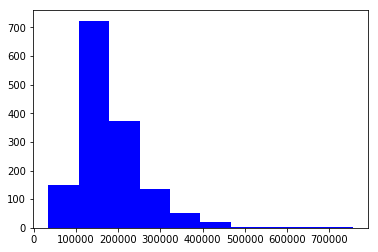

In [6]:
# Analyze target column
print ("Skew is:", df_train.SalePrice.skew())
plt.hist(df_train.SalePrice, color='blue')
plt.show()

Skew is: 0.12133506220520406


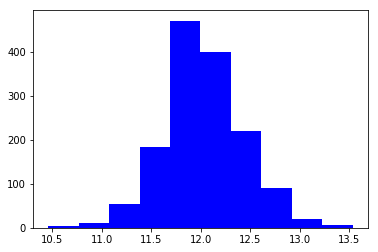

In [7]:
#Transform Sale Price column with logaritm transformation

target = np.log(df_train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

In [8]:
# Working with Numeric Features
numeric_features = df_train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [9]:
# Analysis of OverallQual
df_train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

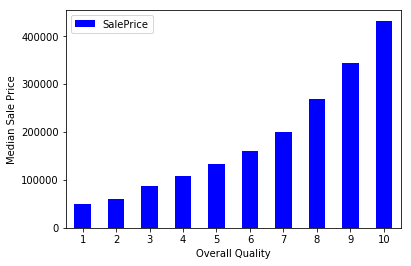

In [10]:
quality_pivot = df_train.pivot_table(index='OverallQual',
                                  values='SalePrice', aggfunc=np.median)
quality_pivot
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

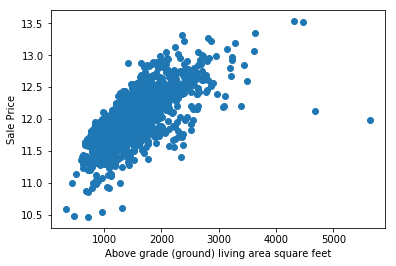

In [11]:
#  GrLivArea
plt.scatter(x=df_train['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()

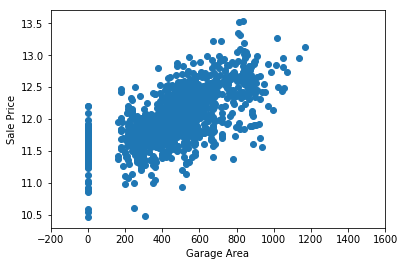

In [12]:
#GarageArea
df_train = df_train[df_train['GarageArea'] < 1200]

plt.scatter(x=df_train['GarageArea'], y=np.log(df_train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

## Method 1 - Base line model

In [13]:
#Base line model

def clean_data(df):
    return df

def transform_features(df):
    return df

def select_features(df):
    return df[["GrLivArea", "SalePrice"]]

def train_and_test(df):  
    train = df[:int(3*df.shape[0]/4)]
    test = df[int(3*df.shape[0]/4):]
    
    ## You can use `pd.DataFrame.select_dtypes()` to specify column types
    ## and return only those columns as a data frame.
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    ## You can use `pd.Series.drop()` to drop a value.
    train = train.dropna(axis = 0)
    test = test.dropna(axis = 0)
    
    features = numeric_train.columns.drop("SalePrice")
    lr = LinearRegression()
    
    ## log target
    #lr.fit(train[features], np.log(train["SalePrice"]))
    lr.fit(train[features], train["SalePrice"])
           
    predictions = lr.predict(test[features])
    #mse = mean_squared_error(test["SalePrice"], np.exp(predictions))
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

clean_df =  clean_data(df_train)
transform_df = transform_features(clean_df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55155.69096514637

## Improve functions to pipeline

In [14]:
from sklearn.preprocessing import minmax_scale

def clean_data(train):
 
    train_cp = train.copy()
    
    ## MISSING VALUES ###
    
    #Drop any with 5% or more missing values
    threshold = np.round(0.05*len(train_cp))   
    missing_values =  train_cp.isnull().sum()

    cols_to_drop = missing_values[missing_values > threshold] 
    df_no_mv = train_cp.drop(cols_to_drop.index, axis = 1)

    #Drop any with 1 or more missing values for non-numerical for now.
    non_numeric = df_no_mv.select_dtypes(include=['object'])
    missing_values =  non_numeric.isnull().sum()

    drop_missing = missing_values[missing_values > 0]
    df_no_mv = df_no_mv.drop(drop_missing.index, axis = 1)

    #Counting missing values
    missing_values =  df_no_mv.isnull().sum()
    cols_missing = missing_values[missing_values > 0]
    
    #For columns with less than 5% missing values, fill with most popular value
    for item in cols_missing.index:
        items_counts = df_no_mv[item].value_counts()
        max_item = items_counts.max()
        df_no_mv[item] = df_no_mv[item].fillna(max_item)
    
    missing_values =  df_no_mv.isnull().sum()
    #print(missing_values.value_counts())
    
    ## Rescaling ##
    
    #numerical_data = df_no_mv.select_dtypes(include=['int64', 'float64'])
    #features = numerical_data.columns.drop("SalePrice")
    #df_no_mv[features] = minmax_scale(df_no_mv[features])

    
    return df_no_mv

In [15]:
#Update feature selection

def select_features(train):
    train_cp = train.copy()
    
    ## Using only numerical columns9
    numerical_data = train_cp.select_dtypes(include=['int64', 'float64'])
    target = 'SalePrice'
    #numerical_features = numerical_data.columns
    
    # 1-Generation of a correlation heatmap matrix
    corrmat = numerical_data.corr()
    corrprice = np.abs(corrmat[target])  
    
    
    #print (corrmat['SalePrice'].sort_values(ascending=False)[:5], '\n')
    #print (corrmat['SalePrice'].sort_values(ascending=False)[-5:])

    cols_to_drop = list(corrprice[corrprice <0.1].index)
    #print(cols_to_drop)

    
    #2 - collinearity between some of these feature column (generate a correlation matrix heatmap using Seaborn)
    corrmat = numerical_data.corr()
    #ax = sns.heatmap(corrmat[abs(corrmat) > 0.5])
    
    ## Plotting the heat map
    plt.figure(figsize=(12,9))
    sns.heatmap(corrmat, vmax = 0.8);
    
    ## Plotting the pair plot for specific columns
    #cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'Fireplaces']
    #sns.pairplot(df_train[cols], size = 2.5);
    
    
    cols_to_drop.append("OverallQual")
    cols_to_drop.append("TotalBsmtSF")
    
    
    
    #3 - Removing Low Variance Features

    vars_= numerical_data.std() / numerical_data.mean()
    sorted_vars = vars_.sort_values()  
#    print(sorted_vars)
    
    cols_to_drop.append("OverallCond")
    cols_to_drop.append("KitchenAbvGr")
    cols_to_drop.append("TotRmsAbvGrd")
    cols_to_drop.append("BedroomAbvGr")
    

    
    #print(train_cp.columns)
    
    #4 - Drop columns that aren't useful for ML or Drop columns that leak info about the final sale
    if "MoSold" in train_cp.columns:
        cols_to_drop.append("MoSold")
    
    if "YrSold" in train_cp.columns:
        cols_to_drop.append("YrSold")
    

    return cols_to_drop

In [16]:
def transform_features(train):
    train_cp = train.copy()

    ## binnig columns ###
    
    #Working with years columns
    year_sold = train_cp['YrSold'] - train_cp['YearBuilt']
    index_to_rm = year_sold[year_sold < 0].index

    
    train_cp['YearBeforeSale'] = year_sold
    train_cp = train_cp.drop(index_to_rm, axis = 0)
    
    year_remod = train_cp['YrSold'] - train_cp['YearRemodAdd']
    index_to_rm = year_remod[year_remod < 0].index
    
    train_cp['YearSinceRemod'] = year_remod
    train_cp = train_cp.drop(index_to_rm, axis = 0)
    train_cp = train_cp.drop(['YearBuilt', 'YearRemodAdd'], axis = 1)
    
    
    ## creating dummies columns ###
    cols_to_drop = []
    categorical_data = train_cp.select_dtypes(include=['object'])
    for col_data in categorical_data.columns:
        categorical_data[col_data] = categorical_data[col_data].astype('category')
        #If there more than 10 unique values -> discard it
        unique_values = len(categorical_data[col_data].unique().tolist())
        if unique_values > 10:
            cols_to_drop.append(col_data)
            pass
        
        #if 95% of data is in unique values -> discard
        value_counts = categorical_data[col_data].value_counts()
        value_per = value_counts/len(categorical_data[col_data])
        
        if max(value_per) > 0.90:
            cols_to_drop.append(col_data)
            pass
    
    categorical_data = categorical_data.drop(cols_to_drop, axis = 1)
    train_cp = train_cp.drop(cols_to_drop, axis = 1)
    
    #Create dummies columns
    dummy_cols = pd.DataFrame()
    for col in categorical_data.columns:
        col_dummies = pd.get_dummies(train_cp[col])
        col_dummies.columns = col + '_' + col_dummies.columns
        train_cp = pd.concat([train_cp, col_dummies], axis=1)
        del train_cp[col]
    
    return train_cp


32645.359469951676


/Users/JoanaSilva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


30728.72243208597
  MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities  \
0       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub   
1       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub   
2       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub   
3       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub   
4       RL         84.0    14260   Pave   NaN      IR1         Lvl    AllPub   

  LotConfig LandSlope    ...    WoodDeckSF OpenPorchSF EnclosedPorch  \
0    Inside       Gtl    ...             0          61             0   
1       FR2       Gtl    ...           298           0             0   
2    Inside       Gtl    ...             0          42             0   
3    Corner       Gtl    ...             0          35           272   
4       FR2       Gtl    ...           192          84             0   

  ScreenPorch PoolQC  Fence  MiscFeature SaleType SaleCondition Sale

29735.71384176373

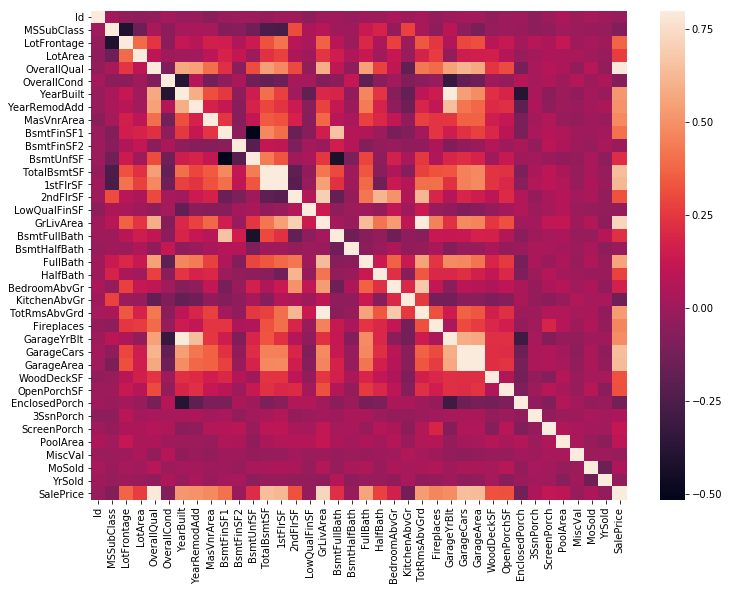

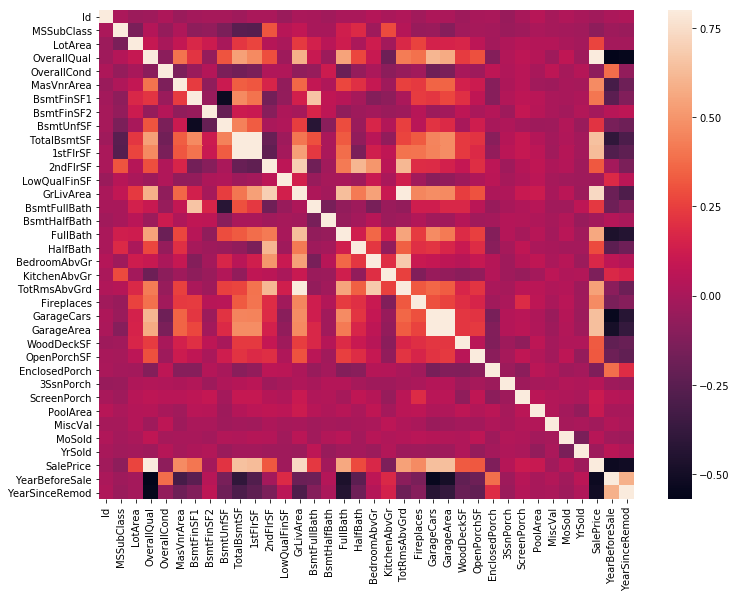

In [17]:
#Pipeline
clean_df = clean_data(df_train)
#transform_df = transform_features(clean_df)
#filtered_df = select_features(transform_df)
rmse_1 = train_and_test(clean_df)
print(rmse_1)


#clean_df = clean_data(df_train)
transform_df = transform_features(df_train)
#filtered_df = select_features(transform_df)
rmse_2 = train_and_test(transform_df)
print(rmse_2)


#clean_df = clean_data(df_train)
#transform_df = transform_features(clean_df)
cols_to_drop = select_features(df_train)
filtered_df = df_train.drop(cols_to_drop, axis = 1)
print(filtered_df.head())
#rmse_3 = train_and_test(filtered_df)
#print(rmse_3)



clean_df = clean_data(df_train)
transform_df = transform_features(clean_df)
cols_to_drop = select_features(transform_df)
filtered_df = transform_df.drop(cols_to_drop, axis = 1)
rmse = train_and_test(filtered_df)

rmse

In [26]:
from sklearn.model_selection import KFold, cross_val_score

def train_and_test(df,k):  
    numeric_train = df.select_dtypes(include=['integer', 'float'])
    features = numeric_train.columns.drop('SalePrice')
    model = LinearRegression()
        
    if (k == 0):   
        train = df[:int(3*df.shape[0]/4)]
        val = df[int(3*df.shape[0]/4):]

        model.fit(train[features], np.log(train["SalePrice"]))
        predictions = np.exp(model.predict(val[features]))
        mse = mean_squared_error(val["SalePrice"], predictions)
        rmse = np.sqrt(mse)
    elif (k == 1):
        train = df[:int(3*df.shape[0]/4)]
        val = df[int(3*df.shape[0]/4):]
    
    
        ## You can use `pd.DataFrame.select_dtypes()` to specify column types
        ## and return only those columns as a data frame.
        for i in [1,2]:
            if i == 2:
                aux = train
                train = val
                val = aux
                
            model.fit(train[features], np.log(train["SalePrice"]))
            predictions = np.exp(model.predict(val[features]))
            mse = mean_squared_error(val["SalePrice"], predictions)
            
            if i == 2:
                rmse += np.sqrt(mse)
                rmse = rmse / 2
            else:
                rmse = np.sqrt(mse)

    else:
        kf = KFold(k, shuffle=True, random_state=1)
        mses = cross_val_score(model,df[features], df["SalePrice"], scoring='neg_mean_squared_error', cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        rmse = np.mean(rmses)

    return [rmse, model]

/Users/JoanaSilva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1454, 101)
29679.332081474102


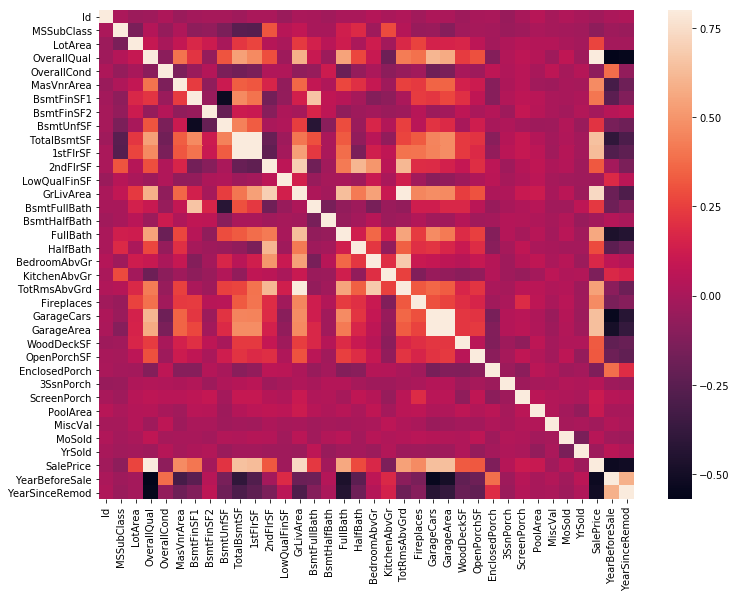

In [28]:
#Pipeline

clean_df = clean_data(df_train)
transform_df = transform_features(clean_df)
cols_to_drop = select_features(transform_df)
filtered_df = transform_df.drop(cols_to_drop, axis = 1)
print(filtered_df.shape)
[rmse, model] = train_and_test(filtered_df, 10)
print(rmse)

